### 04 — Modelling v2 (ML)

This notebook builds and explores ML models which predict the propensity of patients to be readmitted, but this time incorporating features derived from the ICD-9 diagnostic codes.

**Local data source:** `/data/interim/10kDiabetes.csv`

## Executive Summary

This notebook evaluates whether enriching the feature set with ICD-9 diagnostic codes improves model performance over the baseline model in 02_Model.

As seen in [[01_EDA.ipynb](./01_EDA.ipynb)], raw ICD-9 codes greatly expand the feature space, creating a high-dimensional and sparse matrix that is difficult for classical models to learn from without substantial work (feature engineering).

Initial experiments show that simply one-hot encoding diagnosis codes does **not** yield meaningful performance improvements. Extracting value from ICD-9 data will very likely requires grouping codes into identifable comorbidities, which was outside scope given the time constraints.

This notebook therefore demonstrates that throwing extra features and compute at the problem (ICD-9 feature expansion) does not provide a **“quick win”**. 

The **Logistic Regression** baseline model remains the best predictive model available at this point, benefitting additionally from reliability and explainability (**xAI; SHAP**).

| Model                | ROC-AUC | PR-AUC | Notes                 |
|----------------------|--------:|-------:|------------------------|
| Logistic Regression  | 0.703   | 0.600  | Best overall, stable   |
| Random Forest        | 0.685   | 0.556  | Overfitting observed   |
| LR + ICD-9 features  | ~0.69   | ~0.58  | No improvement         |

#### 1. Imports and Project Setup

In [1]:
import sys
import os

project_root = os.path.abspath("..") # Add project root to Python path so we can import data_loader, preprocess, etc etc
if project_root not in sys.path:
    sys.path.append(project_root)

project_root

'C:\\work\\git\\diabetes-readmission-ml'

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # Not too bothered about message "Pyarrow will become a required dependency of pandas"
    import pandas as pd

import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.4)  # try 1.3–1.6

from src.data_loader import load_diabetes_csv, DIABETES_DATA_CSV

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

In [3]:
df = load_diabetes_csv(DIABETES_DATA_CSV,project_root)
df.shape

(10000, 52)

In [4]:
from src.extract_diag import preprocess_extract_diag
df = preprocess_extract_diag(df, 'readmitted')

In [5]:
df[['diag_1_norm','diag_1_norm','diag_1_norm','has_V','has_E','diag_count','readmitted']].head(20)

,diag_1_norm,diag_1_norm,diag_1_norm,has_V,has_E,diag_count,readmitted
0,723,723,723,0,0,2,False
1,664,664,664,0,0,3,False
2,481,481,481,0,0,3,True
3,682,682,682,0,0,3,False
4,296,296,296,0,0,3,False
5,428,428,428,0,0,3,False
6,434,434,434,0,0,3,False
7,558,558,558,0,0,3,False
8,428,428,428,0,0,3,False
9,440,440,440,0,0,2,True


In [6]:
from src.preprocess import preprocess_impute_scale_encode

ignorelist = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc']
df = df.drop(columns=ignorelist, errors='ignore')

df_preproc = preprocess_impute_scale_encode(df, 'readmitted')

# Models

In [9]:
# 2.2 Train/Test Split & Baseline Models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve
)

# Assume df_processed is your cleaned DataFrame & 'readmitted' is target
X = df_preproc.drop(columns=['readmitted'])
y = df_preproc['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Baseline models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

y_pred= dict()
y_proba = dict()

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred[name] = model.predict(X_test)
    y_proba[name] = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred[name]),
        'Precision': precision_score(y_test, y_pred[name]),
        'Recall': recall_score(y_test, y_pred[name]),
        'F1': f1_score(y_test, y_pred[name]),
        'ROC-AUC': roc_auc_score(y_test, y_proba[name])
    }

import pandas as pd
results_df = pd.DataFrame(results).T
results_df


,Accuracy,Precision,Recall,F1,ROC-AUC
LogisticRegression,0.6605,0.594684,0.451450,0.513262,0.683292
RandomForest,0.6585,0.631579,0.332913,0.436003,0.685677


# Logistic Regression

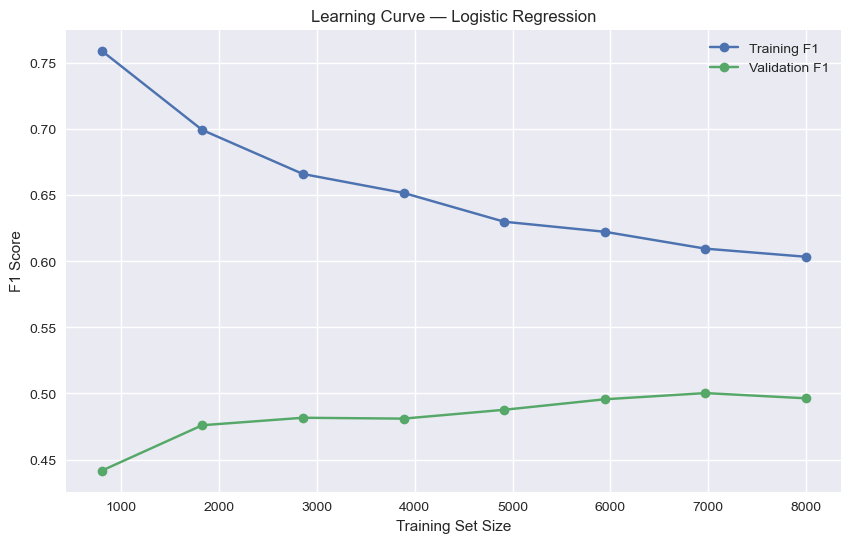

In [12]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    models['LogisticRegression'],
    X, y,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training F1')
plt.plot(train_sizes, val_mean, 'o-', label='Validation F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve — Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()

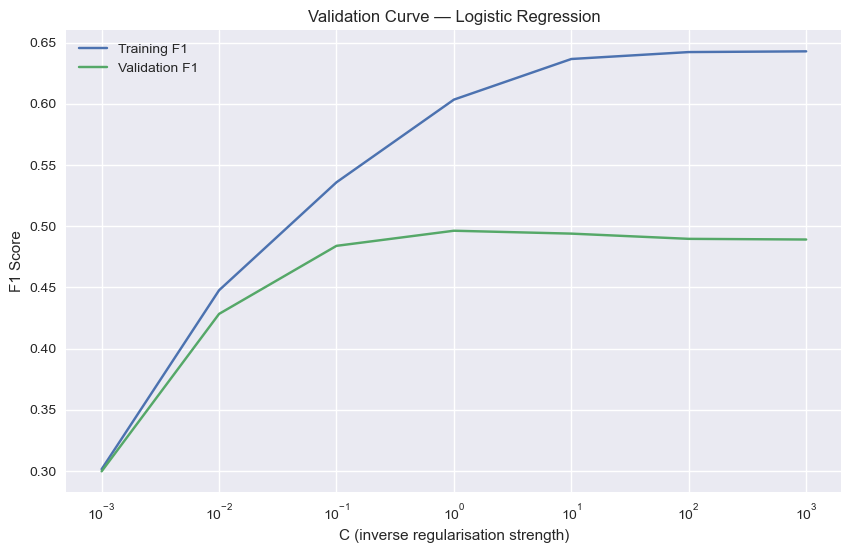

In [13]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 7)

train_scores, val_scores = validation_curve(
        models['LogisticRegression'],
    X, y,
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.semilogx(param_range, train_scores.mean(axis=1), label="Training F1")
plt.semilogx(param_range, val_scores.mean(axis=1), label="Validation F1")
plt.xlabel('C (inverse regularisation strength)')
plt.ylabel('F1 Score')
plt.title('Validation Curve — Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()

Average Precision (PR-AUC): 0.583
Area under PR-curve (by trapezoid): 0.583


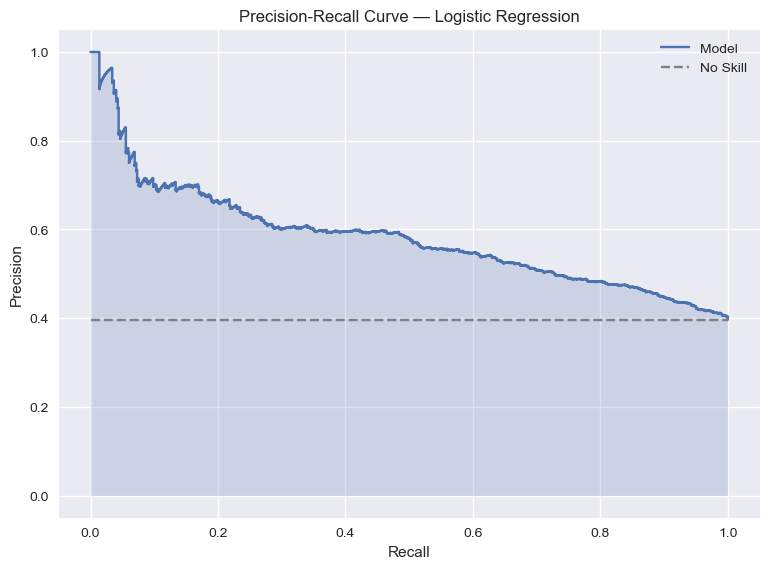

In [14]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

model_choice = 'LogisticRegression'
# Assume:
#   y_test – the actual binary labels (0/1) for the test set
#   y_proba – the predicted probabilities for the positive class (model.predict_proba(X_test)[:,1])

# Compute precision/recall pairs for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[model_choice])

# Compute average precision (PR-AUC)
pr_auc = average_precision_score(y_test, y_proba[model_choice])

# Compute area under the precision-recall curve (alternate)
pr_auc_trap = auc(recall, precision)

print(f"Average Precision (PR-AUC): {pr_auc:.3f}")
print(f"Area under PR-curve (by trapezoid): {pr_auc_trap:.3f}")

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label='Model')
plt.fill_between(recall, precision, step='post', alpha=0.2)

# Plot the no-skill line (precision equal to prevalence)
no_skill = sum(y_test==1) / len(y_test)
plt.hlines(no_skill, 0, 1, linestyle='--', color='grey', label='No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — Logistic Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest

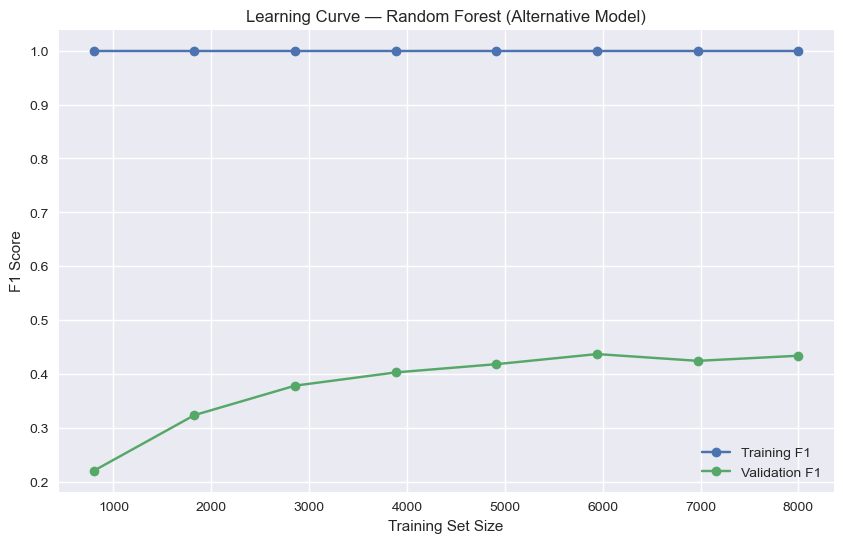

In [15]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    models['RandomForest'],
    X, y,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training F1')
plt.plot(train_sizes, val_mean, 'o-', label='Validation F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve — Random Forest')
plt.grid(True)
plt.legend()
plt.show()

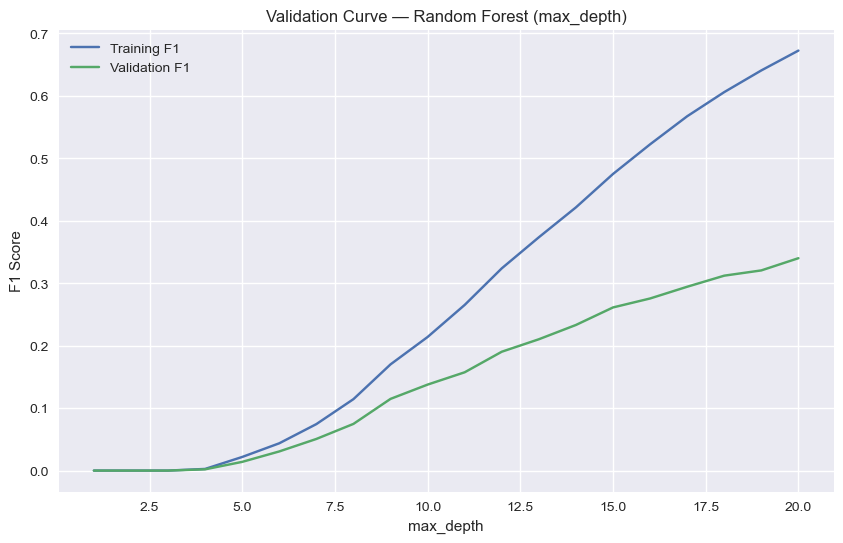

In [16]:
from sklearn.model_selection import validation_curve
import numpy as np
import matplotlib.pyplot as plt

param_range = np.arange(1, 21)

train_scores, val_scores = validation_curve(
    models['RandomForest'],
    X, y,
    param_name='max_depth',
    param_range=param_range,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores.mean(axis=1), label='Training F1')
plt.plot(param_range, val_scores.mean(axis=1), label='Validation F1')
plt.xlabel('max_depth')
plt.ylabel('F1 Score')
plt.title('Validation Curve — Random Forest (max_depth)')
plt.grid(True)
plt.legend()
plt.show()

Average Precision (PR-AUC): 0.566
Area under PR-curve (by trapezoid): 0.567


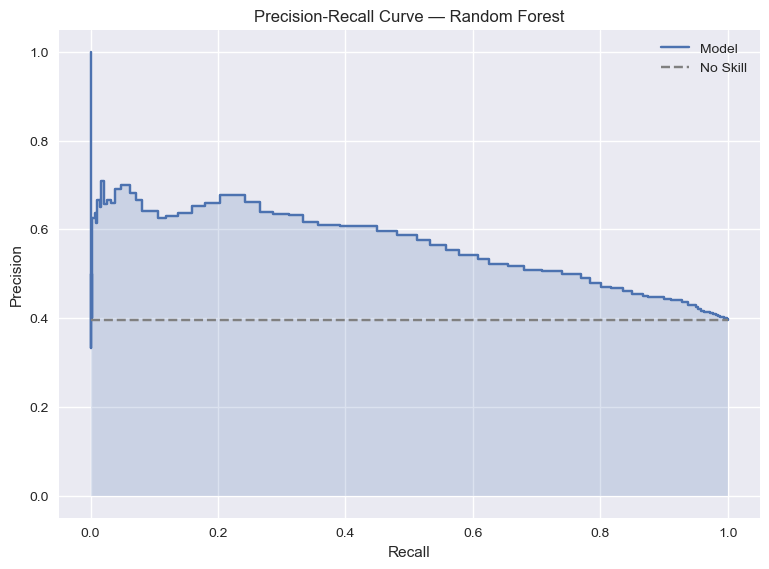

In [17]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

model_choice = 'RandomForest'
# Assume:
#   y_test – the actual binary labels (0/1) for the test set
#   y_proba – the predicted probabilities for the positive class (model.predict_proba(X_test)[:,1])

# Compute precision/recall pairs for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[model_choice])

# Compute average precision (PR-AUC)
pr_auc = average_precision_score(y_test, y_proba[model_choice])

# Compute area under the precision-recall curve (alternate)
pr_auc_trap = auc(recall, precision)

print(f"Average Precision (PR-AUC): {pr_auc:.3f}")
print(f"Area under PR-curve (by trapezoid): {pr_auc_trap:.3f}")

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label='Model')
plt.fill_between(recall, precision, step='post', alpha=0.2)

# Plot the no-skill line (precision equal to prevalence)
no_skill = sum(y_test==1) / len(y_test)
plt.hlines(no_skill, 0, 1, linestyle='--', color='grey', label='No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()